In [2]:
%env CUDA_VISIBLE_DEVICES=0
import torch
import text
import glob
import matplotlib.pyplot as plt 

from IPython.display import Audio
from omegaconf import OmegaConf
from model.main import TacotronTrain

env: CUDA_VISIBLE_DEVICES=0


In [2]:
! ls logs/ai3_gmm/lightning_logs/

version_0  version_1


In [3]:
device = 'cpu'
cfg_path = 'configs/cfg_ai3.yaml'
ckpt_path = sorted(glob.glob('logs/ai3_gmm/lightning_logs/version_1/checkpoints/*.ckpt'))[-1]
print(f'choosen ckpt path: {ckpt_path}')

cfg = OmegaConf.load(cfg_path)
tacotron = TacotronTrain.load_from_checkpoint(ckpt_path, map_location=device, cfg=cfg).to(device)

choosen ckpt path: logs/ai3_gmm/lightning_logs/version_1/checkpoints/epoch=60-step=79944.ckpt


/Netdata/shiyao/speechhome-ai3/model/stft.py:67: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/Netdata/shiyao/speechhome-ai3/model/layers.py:51: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=8000.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [22]:
import argparse
import json
from hifigan.models import Generator

with open('hifigan/config_v1.json') as f: 
    h = argparse.Namespace(**json.load(f))
    
vocoder = Generator(h)
vocoder.load_state_dict(torch.load('../hifi-gan/official_ckpt/UNIVERSAL_V1/g_02500000')['generator'])
vocoder.remove_weight_norm()

def hifigan_inference(mel: torch.Tensor) -> torch.Tensor: 
    with torch.no_grad(): 
        return vocoder(mel[None].to(next(vocoder.parameters()).device)).squeeze().cpu()

Removing weight norm...


In [9]:
cntxt = '他的著作具有大无畏的尖刻讽刺精神'
inpt = text.cn_to_sequence(cntxt)
spkid = 0

tacotron.tacotron.decoder.gate_threshold = 0.05
mel_before, mel_after, gate, alignment, gl_wave = tacotron.inference(inpt, spkid, use_gl=True)
gan_wave = hifigan_inference(mel_after)


/Netdata/shiyao/speechhome-ai3/audio_processing.py:50: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  win_sq = librosa_util.pad_center(win_sq, n_fft)


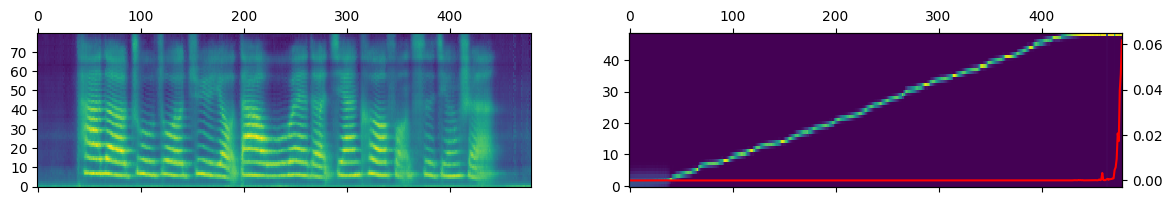

In [10]:
%matplotlib inline
fig, (ax_mel, ax_align) = plt.subplots(1, 2, figsize=(14,2))
kws = dict(origin='lower', aspect='auto')
ax_mel.matshow(mel_after, **kws)
ax_align.matshow(alignment.T, **kws)
ax_gate = plt.twinx(ax_align)
ax_gate.plot(torch.sigmoid(gate), color='red')
display(Audio(gl_wave, rate=cfg.sampling_rate))
display(Audio(gan_wave, rate=cfg.sampling_rate))